
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries under a climate change scenario (future TCs occurrence probability)

inputs required: 
  * Historical DWTs (for plotting)
  * Historical wave families (for plotting)
  * Synthetic DWTs
  * Historical intradaily hydrograph parameters  
  * TCs waves
  * **Future TCs occurrence probability**
  
in this notebook:
  * Generate synthetic time series of wave conditions   
  * Validate the synthetic waves by means of mean distributions
  * 
  <span style='color:Red'> TODO: ¿¿Compare the synthetic waves by means of mean distributions **(with and without climate change)**??. Solo comparamos con 1 simulación así que no sé si tiene mucho sentido  </span>

In the case on **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio. 
The probability of entering the 4 degree radio (from the 14 degree radio) is modified according to future changes under a climate change scenario





In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import shutil


# pip
import numpy as np
import xarray as xr
np.set_printoptions(precision=3)
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_change import Plot_RCP_ocurrence



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S4
db_S4 = Database(p_data)
db_S4.SetSite('ROI_CC_S4')


# climate emulator simulation modified path
p_S4_CE_sims = op.join(db_S4.paths.site.EXTREMES.climate_emulator, 'Simulations')


In [3]:
# --------------------------------------
# Load data for plotting (waves partitions and families, KMA, DWT)

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

TCs_probs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
TCs_pchange = TCs_probs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each DWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


# --------------------------------------
# Load climate change data

lon_rcp, lat_rcp, RCP85ratioHIST_occurrence = db.Load_RCP85()


In [4]:
# TODO developer
DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))


## Obtain future TCs occurence probability 

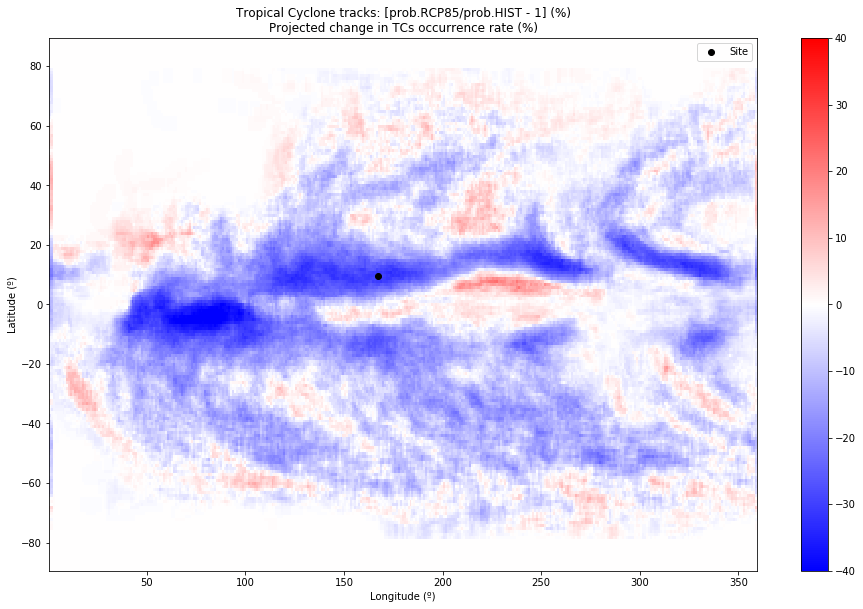

In [5]:
# ROI point
lon_p = 167.5
lat_p = 9.75

# find closest point at RCP data
lon_g, lat_g = np.meshgrid(lon_rcp, lat_rcp)
dif = np.sqrt((lon_g - lon_p)**2 + (lat_g - lat_p)**2)
min_ind = np.where(dif == np.min(dif))
ix_lon, ix_lat = min_ind[0], min_ind[1]

# TCs ocurrence probability at site
TCs_occurrence_prob = RCP85ratioHIST_occurrence[ix_lon, ix_lat]

# Plot global map and location of Site
Plot_RCP_ocurrence(lon_g, lat_g, RCP85ratioHIST_occurrence, ix_lon, ix_lat);


#--------------------------------------
# Modify future probability of a TC affecting the site (modify probability of TC in r1, entering r2)

TCs_pchange +=  TCs_pchange * TCs_occurrence_prob/100.0



## Climate Emulator - Simulation

In [7]:
# --------------------------------------
# Climate Emulator extremes model fitting

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# set a new path for S4 simulations
CE.Set_Simulation_Folder(p_S4_CE_sims, copy_WAVES_noTCs = True)  # waves (no TCs) already simulated

# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)
    
    # Load previously simulated waves (no TCs)
    WVS_sim, _, _ = CE.LoadSim(n_sim=int(n))

    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, TCs_pchange, MU_WT, TAU_WT)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))


- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 113899/113899 [00:04<00:00, 24443.60it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 113749/113749 [00:04<00:00, 27029.58it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 113554/113554 [00:04<00:00, 27108.54it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 113698/113698 [00:04<00:00, 28330.29it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 114541/114541 [00:04<00:00, 25321.67it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 113181/113181 [00:04<00:00, 26924.36it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 113863/113863 [00:05<00:00, 20246.43it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 114172/114172 [00:04<00:00, 23469.58it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 114256/114256 [00:07<00:00, 14960.25it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 113880/113880 [00:04<00:00, 26705.18it/s]


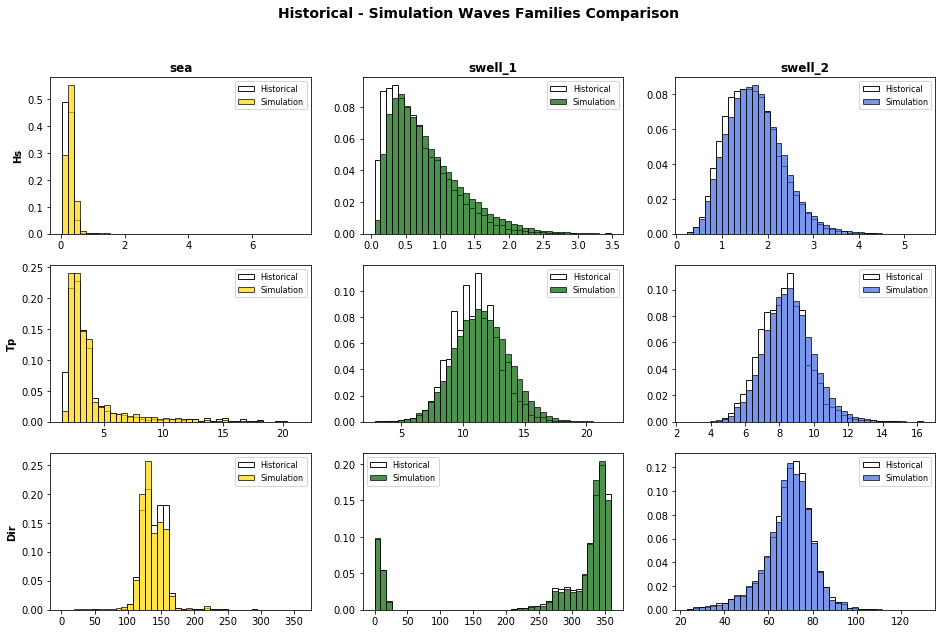

In [8]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim = n_sim_CE));
